# 基本的な操作の確認と予測
操作の確認と、各種ベースラインとなる予測手法を動かしてみる。手を動かすことを目的とする。
##　結果
- 芳香環の有無や個数が最大吸収波長に高い相関を持つ　→ ベンゼン環の構造を学習させる方法が有用である可能性
- モルガンフィンガープリントに、次元削減はあまり役に立たなそうである
- ニューラルネットワークの学習を過学習などを起こさずに行うのが先決そう

In [1]:
import sys
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem

In [3]:
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor

import lightgbm as lgb

In [4]:
dataset_df = pd.read_csv("../datasets/dataset.csv")
for col in dataset_df.columns:
    if col == "SMILES":
        continue
    dataset_df[col] = dataset_df[col].fillna(0)
dataset_df.head()

,SMILES,λmax,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,c1cc2c(cn1)CCc1c[nH]nc1-2,263.321241,4.245324,1.073935,4.245324,1.073935,0.653297,171.203,162.131,171.079647,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CONC(=O)c1n[nH]c2c1CCc1n[nH]cc1-2,243.668931,11.685965,-0.336162,11.685965,0.336162,0.645013,233.231,222.143,233.091275,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,O=C(O)c1[nH]nc2c1CCc1cnccc1-2,221.607321,10.962397,-0.952541,10.962397,0.205984,0.750319,215.212,206.140,215.069477,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,OCc1[nH]nc2c1CCc1cnccc1-2,221.009049,9.146874,0.030506,9.146874,0.030506,0.724880,201.229,190.141,201.090212,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,O=C1C=CC2=C3NNC(C(=O)O)=C3CC2=C1,468.999688,11.186579,-0.992914,11.186579,0.051150,0.581430,216.196,208.132,216.053492,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
print("データ数: {}".format(len(dataset_df)))

データ数: 198655


In [6]:
dataset_df.keys()

Index(['SMILES', 'λmax', 'MaxEStateIndex', 'MinEStateIndex',
       'MaxAbsEStateIndex', 'MinAbsEStateIndex', 'qed', 'MolWt',
       'HeavyAtomMolWt', 'ExactMolWt',
       ...
       'fr_sulfide', 'fr_sulfonamd', 'fr_sulfone', 'fr_term_acetylene',
       'fr_tetrazole', 'fr_thiazole', 'fr_thiocyan', 'fr_thiophene',
       'fr_unbrch_alkane', 'fr_urea'],
      dtype='object', length=210)

In [7]:
df_corr = dataset_df.corr()
df_corr = df_corr.fillna(0)
lambda_max, idx = df_corr["λmax"].to_numpy(), df_corr.index.to_numpy()

In [8]:
for num, i in enumerate(lambda_max.argsort()[::-1][:20]):
    print("{}番相関の高い要素: {}, 相関係数: {}".format(num+1, idx[i], round(lambda_max[i],3)))

1番相関の高い要素: λmax, 相関係数: 1.0
2番相関の高い要素: BertzCT, 相関係数: 0.493
3番相関の高い要素: NumAromaticRings, 相関係数: 0.445
4番相関の高い要素: SMR_VSA7, 相関係数: 0.429
5番相関の高い要素: SlogP_VSA6, 相関係数: 0.424
6番相関の高い要素: fr_aniline, 相関係数: 0.351
7番相関の高い要素: RingCount, 相関係数: 0.35
8番相関の高い要素: HeavyAtomMolWt, 相関係数: 0.335
9番相関の高い要素: VSA_EState6, 相関係数: 0.32
10番相関の高い要素: Chi1, 相関係数: 0.31
11番相関の高い要素: SMR_VSA10, 相関係数: 0.298
12番相関の高い要素: HeavyAtomCount, 相関係数: 0.291
13番相関の高い要素: NumAromaticHeterocycles, 相関係数: 0.286
14番相関の高い要素: SlogP_VSA8, 相関係数: 0.28
15番相関の高い要素: MolWt, 相関係数: 0.28
16番相関の高い要素: ExactMolWt, 相関係数: 0.28
17番相関の高い要素: fr_benzene, 相関係数: 0.275
18番相関の高い要素: NumAromaticCarbocycles, 相関係数: 0.275
19番相関の高い要素: SlogP_VSA10, 相関係数: 0.274
20番相関の高い要素: LabuteASA, 相関係数: 0.269


In [9]:
for num, i in enumerate(lambda_max.argsort()[:20]):
    print("{}番相関の低い要素: {}, 相関係数: {}".format(num+1, idx[i], round(lambda_max[i],3)))

1番相関の低い要素: FractionCSP3, 相関係数: -0.482
2番相関の低い要素: HallKierAlpha, 相関係数: -0.384
3番相関の低い要素: SMR_VSA5, 相関係数: -0.298
4番相関の低い要素: SlogP_VSA5, 相関係数: -0.233
5番相関の低い要素: NumRotatableBonds, 相関係数: -0.221
6番相関の低い要素: SlogP_VSA2, 相関係数: -0.2
7番相関の低い要素: BalabanJ, 相関係数: -0.19
8番相関の低い要素: Kappa2, 相関係数: -0.171
9番相関の低い要素: VSA_EState8, 相関係数: -0.155
10番相関の低い要素: BCUT2D_CHGHI, 相関係数: -0.141
11番相関の低い要素: Kappa3, 相関係数: -0.13
12番相関の低い要素: NumSaturatedRings, 相関係数: -0.127
13番相関の低い要素: NumSaturatedCarbocycles, 相関係数: -0.125
14番相関の低い要素: SMR_VSA4, 相関係数: -0.122
15番相関の低い要素: SMR_VSA1, 相関係数: -0.12
16番相関の低い要素: fr_unbrch_alkane, 相関係数: -0.115
17番相関の低い要素: NumAliphaticCarbocycles, 相関係数: -0.111
18番相関の低い要素: SlogP_VSA3, 相関係数: -0.107
19番相関の低い要素: fr_Al_OH, 相関係数: -0.1
20番相関の低い要素: fr_Al_COO, 相関係数: -0.099


In [10]:
high_corr_idx = idx[lambda_max.argsort()[::-1][1:41]].tolist()
low_corr_idx = idx[lambda_max.argsort()[:20]].tolist()
corr_idx = high_corr_idx + low_corr_idx
corr_idx

['BertzCT',
 'NumAromaticRings',
 'SMR_VSA7',
 'SlogP_VSA6',
 'fr_aniline',
 'RingCount',
 'HeavyAtomMolWt',
 'VSA_EState6',
 'Chi1',
 'SMR_VSA10',
 'HeavyAtomCount',
 'NumAromaticHeterocycles',
 'SlogP_VSA8',
 'MolWt',
 'ExactMolWt',
 'fr_benzene',
 'NumAromaticCarbocycles',
 'SlogP_VSA10',
 'LabuteASA',
 'MolMR',
 'BCUT2D_LOGPLOW',
 'Ipc',
 'fr_ArN',
 'SlogP_VSA1',
 'EState_VSA6',
 'Chi0',
 'VSA_EState4',
 'fr_pyridine',
 'fr_nitro',
 'FpDensityMorgan3',
 'BCUT2D_MRLOW',
 'BCUT2D_MRHI',
 'BCUT2D_CHGLO',
 'NumHAcceptors',
 'SlogP_VSA12',
 'fr_Ar_N',
 'SMR_VSA9',
 'PEOE_VSA5',
 'PEOE_VSA3',
 'BCUT2D_LOGPHI',
 'FractionCSP3',
 'HallKierAlpha',
 'SMR_VSA5',
 'SlogP_VSA5',
 'NumRotatableBonds',
 'SlogP_VSA2',
 'BalabanJ',
 'Kappa2',
 'VSA_EState8',
 'BCUT2D_CHGHI',
 'Kappa3',
 'NumSaturatedRings',
 'NumSaturatedCarbocycles',
 'SMR_VSA4',
 'SMR_VSA1',
 'fr_unbrch_alkane',
 'NumAliphaticCarbocycles',
 'SlogP_VSA3',
 'fr_Al_OH',
 'fr_Al_COO']

In [11]:
df_good = dataset_df[idx[lambda_max.argsort()[::-1][:20]]]
df_good.head()

,λmax,BertzCT,NumAromaticRings,SMR_VSA7,SlogP_VSA6,fr_aniline,RingCount,HeavyAtomMolWt,VSA_EState6,Chi1,SMR_VSA10,HeavyAtomCount,NumAromaticHeterocycles,SlogP_VSA8,MolWt,ExactMolWt,fr_benzene,NumAromaticCarbocycles,SlogP_VSA10,LabuteASA
0,263.321241,444.935437,2.0,35.783801,24.656898,0.0,3.0,162.131,2.035880,6.449490,0.000000,13.0,2.0,11.257379,171.203,171.079647,0.0,0.0,0.0,75.829460
1,243.668931,571.013298,2.0,23.148151,6.196844,0.0,3.0,222.143,0.000000,8.308862,5.907180,17.0,2.0,11.257379,233.231,233.091275,0.0,0.0,0.0,96.515927
2,221.607321,574.358694,2.0,35.280885,18.460054,0.0,3.0,206.140,1.874799,7.770857,5.969305,16.0,2.0,11.257379,215.212,215.069477,0.0,0.0,0.0,91.150158
3,221.009049,504.284183,2.0,35.280885,18.460054,0.0,3.0,190.141,1.981469,7.398178,0.000000,15.0,2.0,11.257379,201.229,201.090212,0.0,0.0,0.0,86.988636
4,468.999688,549.576984,0.0,46.341453,46.341453,0.0,3.0,208.132,0.000000,7.664704,11.752550,16.0,0.0,0.000000,216.196,216.053492,0.0,0.0,0.0,90.799905


In [12]:
df_bad = dataset_df[idx[lambda_max.argsort()[:20]]]
df_bad.tail()

,FractionCSP3,HallKierAlpha,SMR_VSA5,SlogP_VSA5,NumRotatableBonds,SlogP_VSA2,BalabanJ,Kappa2,VSA_EState8,BCUT2D_CHGHI,Kappa3,NumSaturatedRings,NumSaturatedCarbocycles,SMR_VSA4,SMR_VSA1,fr_unbrch_alkane,NumAliphaticCarbocycles,SlogP_VSA3,fr_Al_OH,fr_Al_COO
198650,1.0,-0.08,64.456086,52.372404,6.0,37.120776,2.173750,7.235828,7.253656,2.193006,4.519271,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
198651,1.0,-0.08,77.297729,65.214047,9.0,37.120776,1.952350,8.931040,7.014815,2.181082,6.420080,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
198652,1.0,-0.08,57.532349,45.448667,6.0,37.623692,2.047938,6.412307,3.533984,2.182037,3.970811,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
198653,1.0,-0.08,64.456086,52.372404,7.0,37.120776,2.028333,7.235828,6.847473,2.182607,4.984402,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
198654,1.0,-0.08,59.420076,53.378235,10.0,37.120776,3.347218,10.438224,13.827046,2.018598,8.884932,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


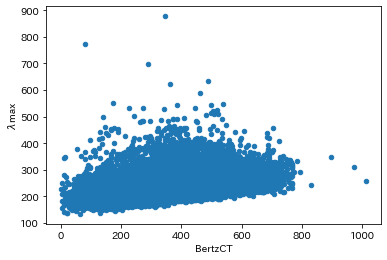

In [13]:
dataset_df.plot.scatter(x="BertzCT", y="λmax")

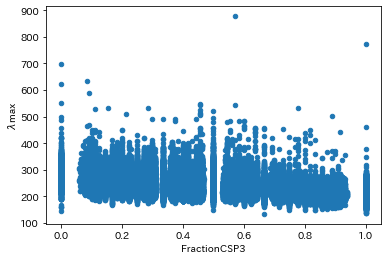

In [14]:
dataset_df.plot.scatter(x="FractionCSP3", y="λmax")

Train Mean Squared Error: 369.1316988989131
Test Mean Squared Error: 367.45564532160955


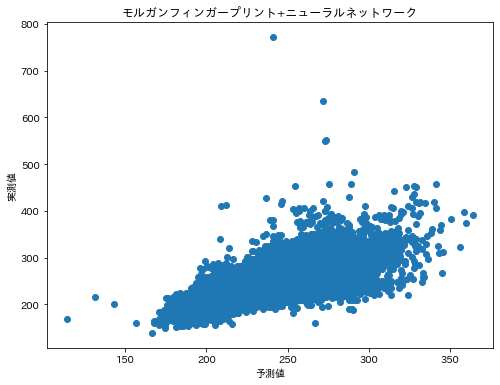

In [27]:
X = dataset_df.drop(['SMILES','λmax','morgan_fingerprint'], axis=1)
y = dataset_df["λmax"]
X_train, X_test, y_train, y_test = train_test_split(X, y)

model = Ridge()
model.fit(X_train, y_train)

pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(pred_test, y_test)
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.set_title(title)

print(f"Train Mean Squared Error: {mse(y_train, pred_train)}")
print(f"Test Mean Squared Error: {mse(y_test, pred_test)}")

Train Mean Squared Error: 446.46763172677976
Test Mean Squared Error: 451.0605646122776


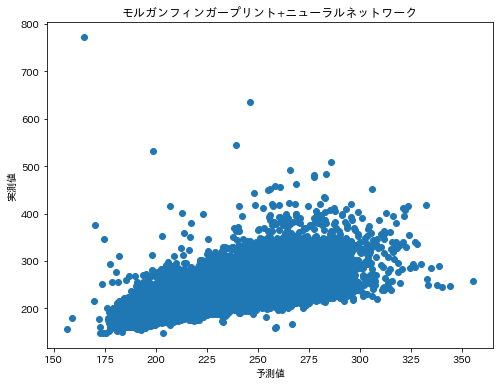

In [28]:
X = dataset_df[corr_idx]
y = dataset_df["λmax"]
X_train, X_test, y_train, y_test = train_test_split(X, y)

model = LinearRegression()
model.fit(X_train, y_train)

pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(pred_test, y_test)
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.set_title(title)

print(f"Train Mean Squared Error: {mse(y_train, pred_train)}")
print(f"Test Mean Squared Error: {mse(y_test, pred_test)}")

Train Mean Squared Error: 368.1054556565281
Test Mean Squared Error: 369.23715357671966


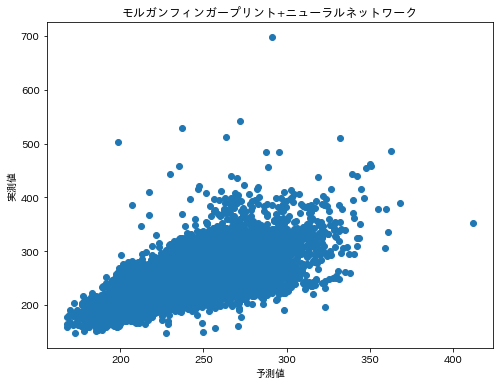

In [29]:
X = dataset_df.drop(['SMILES','λmax','morgan_fingerprint'], axis=1)
y = dataset_df["λmax"]
X_train, X_test, y_train, y_test = train_test_split(X, y)

model = LinearRegression()
model.fit(X_train, y_train)

pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(pred_test, y_test)
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.set_title(title)

print(f"Train Mean Squared Error: {mse(y_train, pred_train)}")
print(f"Test Mean Squared Error: {mse(y_test, pred_test)}")

In [17]:
# Random Forest Regressor は処理が終わらない

In [18]:
# error が起こる
# X = dataset_df[corr_idx]
# y = dataset_df["λmax"]
# X_train, X_test, y_train, y_test = train_test_split(X, y)

# model = lightgbm.LGBMRegressor()
# model.fit(X_train, y_train)

# pred_train = model.predict(X_train)
# pred_test = model.predict(X_test)

# print(f"Train Mean Squared Error: {mse(y_train, pred_train)}")
# print(f"Test Mean Squared Error: {mse(y_test, pred_test)}")

In [19]:
def get_morgan_fingerprint(smile, radius=2, bits=1024):
    mol_ = Chem.MolFromSmiles(smile)
    bit_morgan_ = {}
    if mol_ == None:
        return [0] * bits
    else:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol_, radius=radius, nBits=bits, bitInfo=bit_morgan_)
    return np.array(fp)

In [20]:
# 5min need
%%time
dataset_df["morgan_fingerprint"] = dataset_df["SMILES"].map(get_morgan_fingerprint)
dataset_df.head()

,SMILES,λmax,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,morgan_fingerprint
0,c1cc2c(cn1)CCc1c[nH]nc1-2,263.321241,4.245324,1.073935,4.245324,1.073935,0.653297,171.203,162.131,171.079647,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CONC(=O)c1n[nH]c2c1CCc1n[nH]cc1-2,243.668931,11.685965,-0.336162,11.685965,0.336162,0.645013,233.231,222.143,233.091275,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,O=C(O)c1[nH]nc2c1CCc1cnccc1-2,221.607321,10.962397,-0.952541,10.962397,0.205984,0.750319,215.212,206.140,215.069477,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,OCc1[nH]nc2c1CCc1cnccc1-2,221.009049,9.146874,0.030506,9.146874,0.030506,0.724880,201.229,190.141,201.090212,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,O=C1C=CC2=C3NNC(C(=O)O)=C3CC2=C1,468.999688,11.186579,-0.992914,11.186579,0.051150,0.581430,216.196,208.132,216.053492,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


Train Mean Squared Error: 556.687744387062
Test Mean Squared Error: 570.916979994522


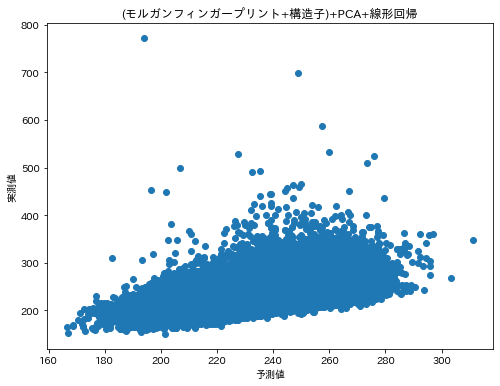

In [21]:
title = "(モルガンフィンガープリント+構造子)+PCA+線形回帰"
x_label = "予測値"
y_label = "実測値"

# データセットの定義と分割
X = np.array(dataset_df["morgan_fingerprint"].values.tolist())
X_rest = dataset_df.drop(['SMILES','λmax',"morgan_fingerprint"], axis=1).values
X = np.hstack([X, X_rest])
y = dataset_df["λmax"].values
X_train, X_test, y_train, y_test = train_test_split(X, y)

# 次元削減
reducer = PCA(n_components=20)
reducer.fit(X_train, y_train)
X_train, X_test = reducer.transform(X_train), reducer.transform(X_test)

# 回帰モデル
model = LinearRegression()
model.fit(X_train, y_train)

# 予測
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(pred_test, y_test)
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.set_title(title)

print(f"Train Mean Squared Error: {mse(y_train, pred_train)}")
print(f"Test Mean Squared Error: {mse(y_test, pred_test)}")

Train Mean Squared Error: 560.9204841784077
Test Mean Squared Error: 557.8278017309589


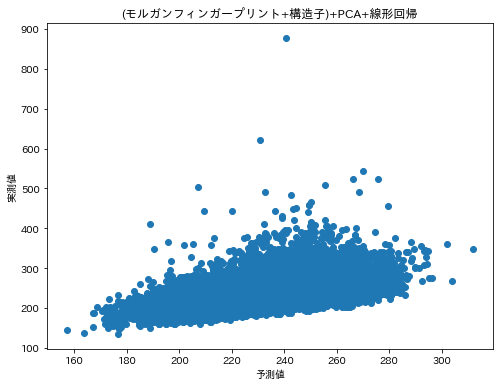

In [22]:
title = "(モルガンフィンガープリント+構造子)+PCA+線形回帰"
x_label = "予測値"
y_label = "実測値"

# データセットの定義と分割
X = np.array(dataset_df["morgan_fingerprint"].values.tolist())
X_rest = dataset_df.drop(['SMILES','λmax',"morgan_fingerprint"], axis=1).values
X = np.hstack([X, X_rest])
y = dataset_df["λmax"].values
X_train, X_test, y_train, y_test = train_test_split(X, y)

# 次元削減
reducer = PCA(n_components=20)
reducer.fit(X_train, y_train)
X_train, X_test = reducer.transform(X_train), reducer.transform(X_test)

# 回帰モデル
model = LinearRegression()
model.fit(X_train, y_train)

# 予測
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(pred_test, y_test)
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.set_title(title)

print(f"Train Mean Squared Error: {mse(y_train, pred_train)}")
print(f"Test Mean Squared Error: {mse(y_test, pred_test)}")

Train Mean Squared Error: 195.74854548699946
Test Mean Squared Error: 283.35619473245873


/var/folders/r9/7lg15w31511bybkl0clk2yr40000gn/T/ipykernel_34037/3069154860.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


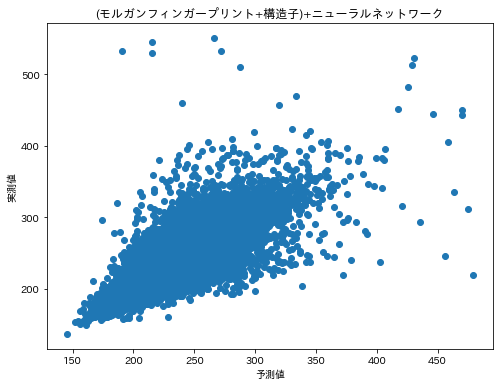

In [23]:
%%time
# 10min
title = "(モルガンフィンガープリント+構造子)+ニューラルネットワーク"
x_label = "予測値"
y_label = "実測値"

# データセットの定義と分割
X = np.array(dataset_df["morgan_fingerprint"].values.tolist())
X_rest = dataset_df.drop(['SMILES','λmax',"morgan_fingerprint"], axis=1).values
X = np.hstack([X, X_rest])
y = dataset_df["λmax"].values
X_train, X_test, y_train, y_test = train_test_split(X, y)

# 次元削減
# reducer = PCA(n_components=20)
# reducer.fit(X_train, y_train)
# X_train, X_test = reducer.transform(X_train), reducer.transform(X_test)

# 回帰モデル
model = MLPRegressor(hidden_layer_sizes=(100,100,))
model.fit(X_train, y_train)

# 予測
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(pred_test, y_test)
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.set_title(title)

print(f"Train Mean Squared Error: {mse(y_train, pred_train)}")
print(f"Test Mean Squared Error: {mse(y_test, pred_test)}")

/Users/takumiinui/opt/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Train Mean Squared Error: 42.639590551882186
Test Mean Squared Error: 429.7552884973771


/var/folders/r9/7lg15w31511bybkl0clk2yr40000gn/T/ipykernel_34037/437412198.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


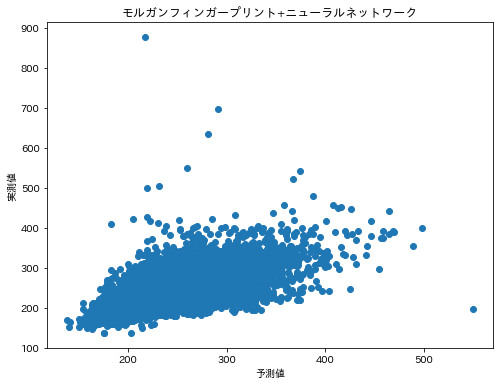

In [24]:
title = "モルガンフィンガープリント+ニューラルネットワーク"
x_label = "予測値"
y_label = "実測値"

# データセットの定義と分割
X = dataset_df["morgan_fingerprint"].values.tolist()
y = dataset_df["λmax"].values
X_train, X_test, y_train, y_test = train_test_split(X, y)

# 次元削減
# reducer = PCA(n_components=20)
# reducer.fit(X_train, y_train)
# X_train, X_test = reducer.transform(X_train), reducer.transform(X_test)

# 回帰モデル
model = MLPRegressor(hidden_layer_sizes=(100,100,))
model.fit(X_train, y_train)

# 予測
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(pred_test, y_test)
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.set_title(title)

print(f"Train Mean Squared Error: {mse(y_train, pred_train)}")
print(f"Test Mean Squared Error: {mse(y_test, pred_test)}")